# Lecture Notes: Basic Image Processing
Before jumping to build powerful and intelligent models for visual recognition it is always important to look at some pixels. Looking at images and pixels and transforming them in various ways gives us often valuable intuitions on how to find things about images.

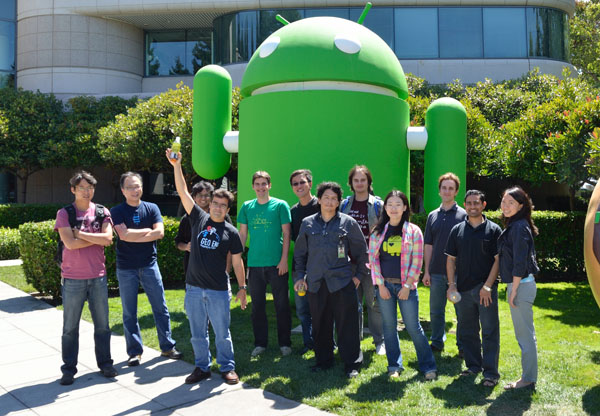

In [175]:
torch.setdefaulttensortype('torch.FloatTensor') -- use floats as the default data type.
image = require 'image' -- load the torch image library.

-- Download image using this line or manually from the following url, or use any other image.
os.execute('wget http://www.cs.virginia.edu/~vicente/images/google_android.jpg');
rgb_image = image.load('google_android.jpg')
itorch.image(rgb_image)

The rgb_image variable contains a FloatTensor of size channels x height x width corresponding to the dimensions of the image. Each entry is between 0 and 1.

In [56]:
print('Number of channels: ' .. rgb_image:size(1))
print('Image height: ' .. rgb_image:size(2))
print('Image width: ' .. rgb_image:size(3))
print('Tensor type: ' .. torch.type(rgb_image))
print('Max value: ' .. rgb_image:max())
print('Min value: ' .. rgb_image:min())

Number of channels: 3	
Image height: 416	
Image width: 600	
Tensor type: torch.FloatTensor	
Max value: 1	
Min value: 0	


## 1. Image channels
We can slice the image into each R, G, and B channels and show them separately:

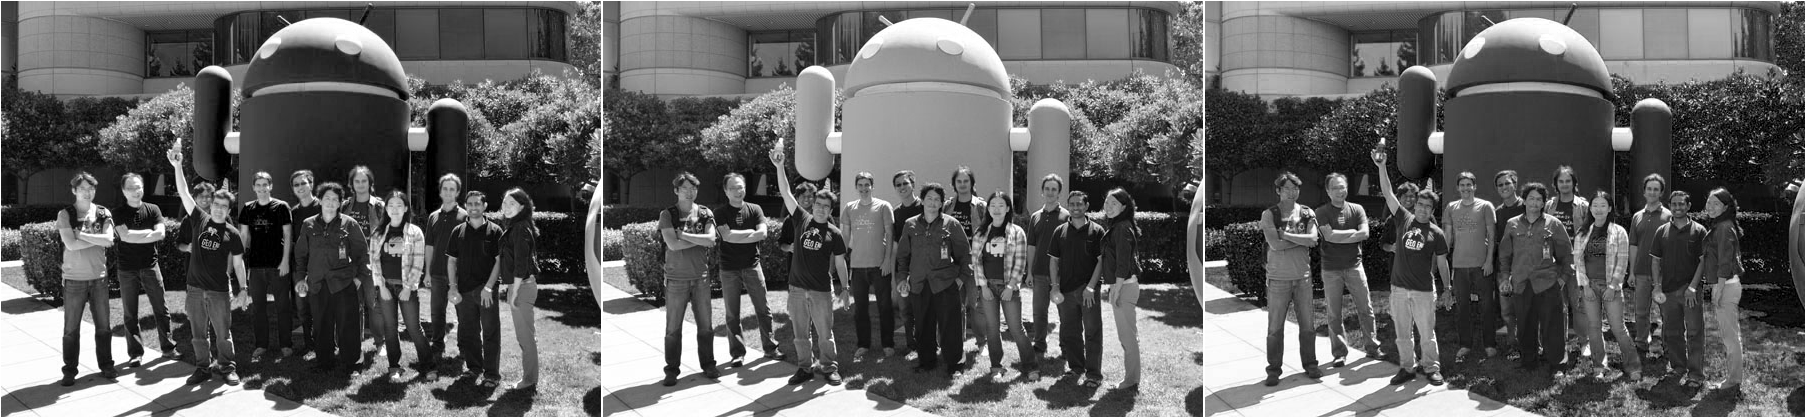

In [57]:
local red_image = rgb_image[{{1}, {}, {}}]
local green_image = rgb_image[{{2}, {}, {}}]
local blue_image = rgb_image[{{3}, {}, {}}]

itorch.image({red_image, green_image, blue_image})

Each image in the above code is a one-channel image (e.g. grayscale image) corresponding to each RGB channel. You can clearly notice the Android figure looks brighter in the Green channel. We could also show each channel by setting to zero the channels corresponding to the other images.

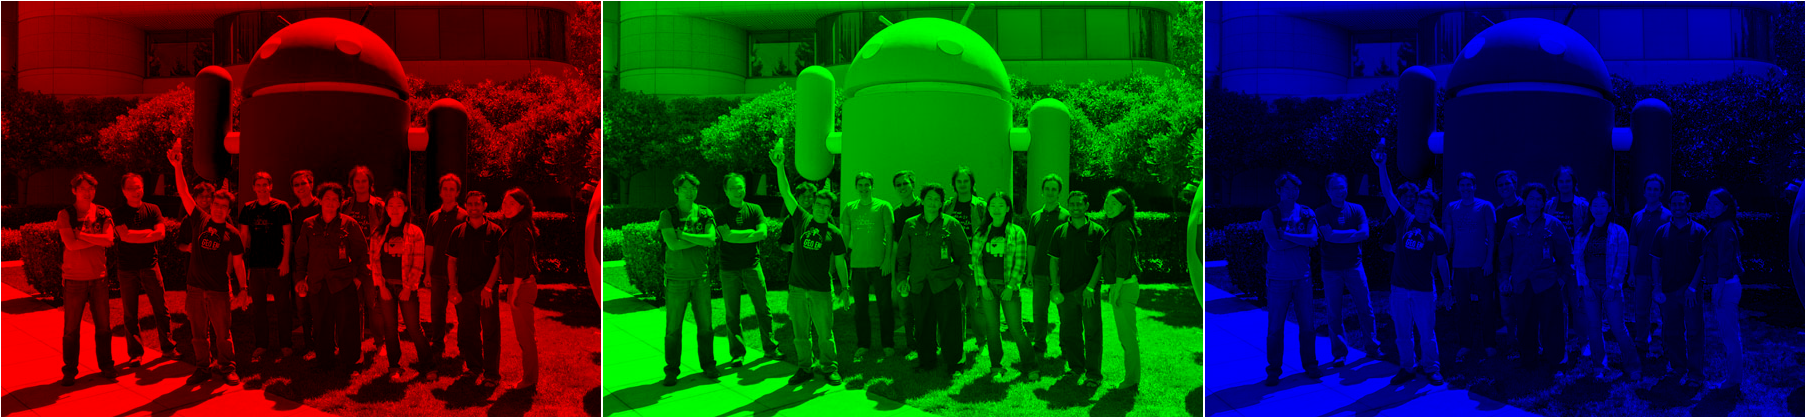

In [58]:
local red_image = rgb_image:clone()
red_image[{{2}, {}, {}}]:zero()
red_image[{{3}, {}, {}}]:zero()

local green_image = rgb_image:clone()
green_image[{{1}, {}, {}}]:zero()
green_image[{{3}, {}, {}}]:zero()

local blue_image = rgb_image:clone()
blue_image[{{1}, {}, {}}]:zero()
blue_image[{{2}, {}, {}}]:zero()

itorch.image({red_image, green_image, blue_image})

## 2. Converting to Grayscale
How do we convert an RGB image to grayscale? A simple way would be to average all three RGB channels. Note the division by 3, since each channel has values between 0 and 1, we want to make sure the resulting grayscale image also has values between 0 and 1.

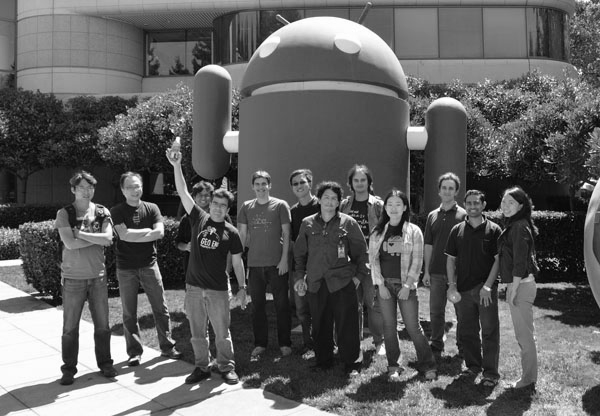

In [59]:
local red_image = rgb_image[{{1}, {}, {}}]
local green_image = rgb_image[{{2}, {}, {}}]
local blue_image = rgb_image[{{3}, {}, {}}]

local gray_image = (red_image + green_image + blue_image) / 3  
itorch.image(gray_image)

A better way to convert a color RGB image into a grayscale image is using a weighted average for instance:

gray_image = 0.4 $*$ red_image + 0.4 $*$ green_image + 0.2 $*$ blue_image;

Why? To reproduce better how most humans perceive the images. We do not have the same sensitivity for all three channels, the coefficients reflect this. We are considerbly less sensative to blue. Here is a more detailed exposition about this on wikipedia: https://en.wikipedia.org/wiki/Grayscale#Colorimetric_.28luminance-preserving.29_conversion_to_grayscale 

## 3. Other Color Spaces
In addition to RGB images, we can represent images as HSL, where each channel corresponds to Hue, Saturation and Lightness instead. Other color spaces include: HSV, Lab, YUV, etc. Sometimes representing an image in some of these other ways might be more beneficial for a given analysis. For instance if we want to focus only on Hue and Saturation but we do not care too much about Lightness. Torch has convenient operations to make this transformations.

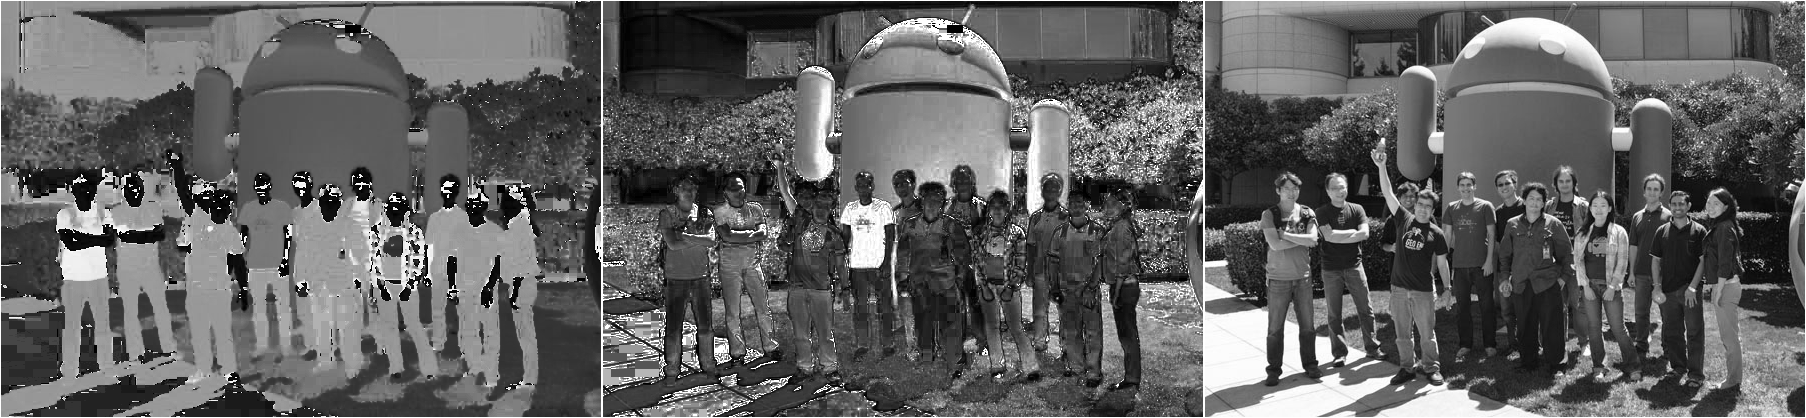

In [65]:
local hsl_image = image.rgb2hsl(rgb_image)

local h_channel = hsl_image[{{1}, {}, {}}]
local s_channel = hsl_image[{{2}, {}, {}}]
local l_channel = hsl_image[{{3}, {}, {}}]

itorch.image({h_channel, s_channel, l_channel})

Notice how the Hue channel tries to output a flat value for regions that are supposed to be the same color (e.g. t-shirts) regardless of luminance. The Saturation channel tries to output higher (brighter) values for regions that have more intense colors (e.g. the Android), and the luminance channel outputs something similar to the original image. You can also deduce that the RGB color space outputs roughly three different versions of luminance. 

## 4. Brightness
Making an image brighter is achieved by multiplying the pixels in the image by a scalar (making sure the values are still between 0 and 1)

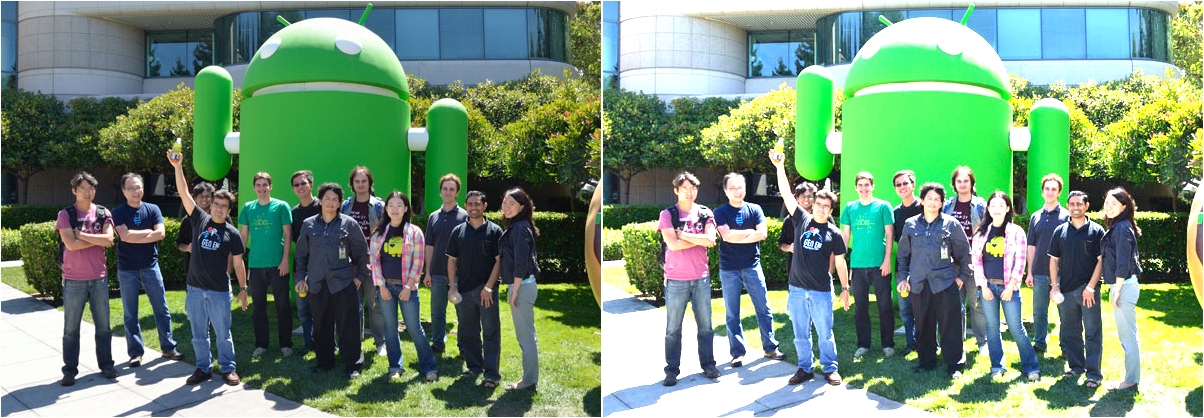

In [60]:
local brighter_image = rgb_image:clone()
-- Go through each channel.
for c = 1, rgb_image:size(1) do
    -- Go through each row.
    for i = 1, rgb_image:size(2) do
        -- Go through each column.
        for j = 1, rgb_image:size(3) do
            brighter_image[{c, i, j}] = 1.8 * rgb_image[{c, i, j}]  -- scale pixel intensity.
            -- make sure the intensity is within 0 and 1.
            if brighter_image[{c, i, j}] > 1 then
                brighter_image[{c, i, j}] = 1
            end
        end
    end
end
-- The above code is slow. 
itorch.image({rgb_image, brighter_image})

Modifying each pixel intensity one by one using three for loops is slow. The efficient way to do this would be to program the three for loops in a lower level language like C/C++. Fortunately Torch has many efficient tensor operations implemented in C/C++. This means that if we can find a way to implement the above code using functions provided by Torch we not need to write any C/C++ to obtain good performance. For instance:

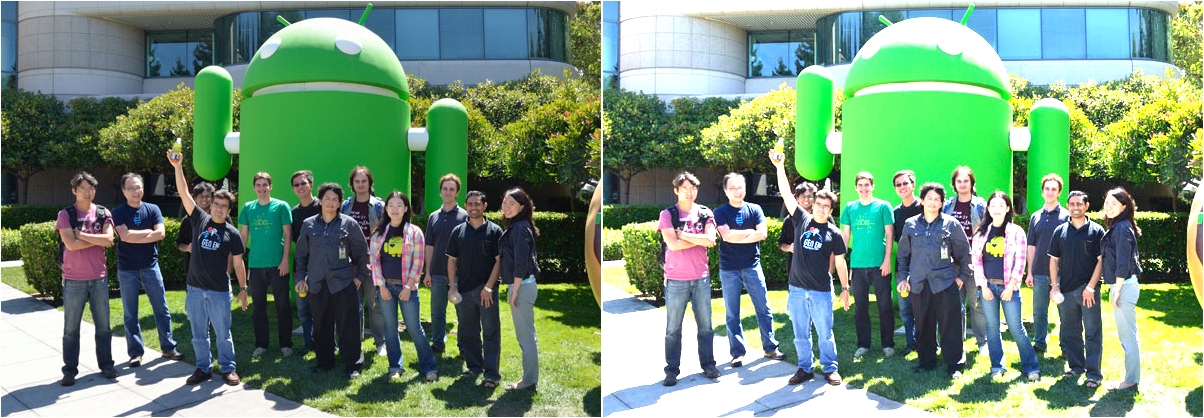

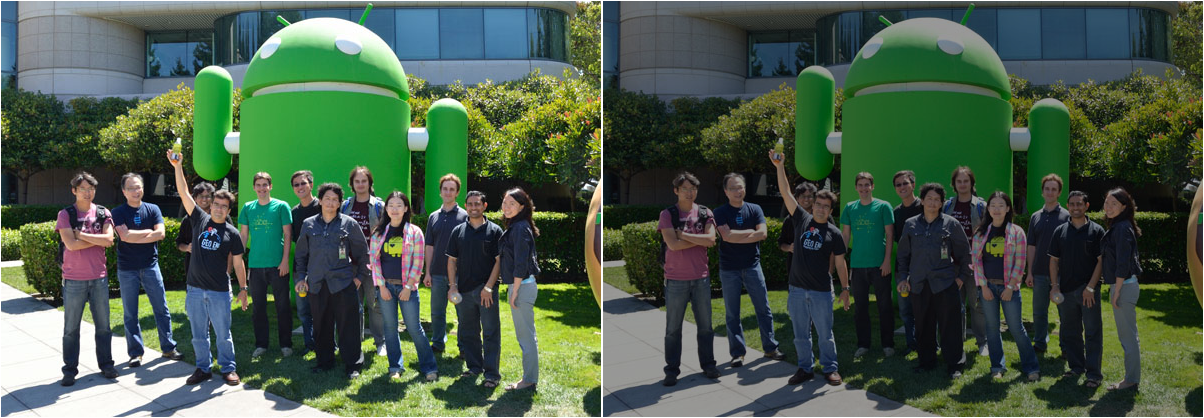

In [61]:
local brighter_image = rgb_image:clone()  -- copy the original image.
brighter_image:mul(1.8) -- in-place multiplication with scalar.
brighter_image:cmin(1)  -- in-place assignment of min value between current value and 1.

-- This implementation is efficient because mul, and cmin are implemented efficiently. 
itorch.image({rgb_image, brighter_image})

-- Let's also try to make the image darker.
local darker_image = rgb_image:clone()
darker_image:mul(0.6) 
-- no need to make sure the image is within 0 and 1 in this case.
itorch.image({rgb_image, darker_image})

There is a way to make things even faster. The C/C++ code will still have to go through every channel, row, and column using three for loops. The answer is GPU computing. Graphics processors are especialized hardware that you might have used to play high end videogames. GPU's can take an enormous amount of vertices (x, y, z) and translate them, rotate them, etc in real time by processing them in parallel. This means the GPU can transform a set of vertices without using a for loop, because it assigns a small processor to each vertex. However, there is nothing preventing us to use the GPU to process things other than vertices. This is the principe behind general purpose GPU computing. Torch has implemented most of its operations also on the GPU using CUDA. This means that we again do not need to program CUDA to compute most of the stuff as long as we use Torch functions and have a CUDA capable GPU (NVIDIA). 

In [ ]:
-- This requires an NVIDIA GPU, and having the CUDA libraries installed as well as cutorch.
require 'cutorch'

local brighter_image = rgb_image:clone()

brighter_image:cuda() -- move image to GPU memory (this operation is expensive).

brighter_image:mul(1.8) -- this operation is computed in the GPU.
brighter_image:cmin(1) -- this operation is equally fast.

itorch.image({rgb_image, brighter_image})

## 5. Histograms
Histograms are useful because while images can be of different sizes, histograms can be computed to be of the same size. Additionally we can normalize histograms so they sum to 1, or their L-2 norm is 1. 

In [226]:
local red_image = rgb_image[{{1}, {}, {}}]
local green_image = rgb_image[{{2}, {}, {}}]
local blue_image = rgb_image[{{3}, {}, {}}]

-- compute a histogram with 10 bins for each channel.
local n_bins = 10
local red_hist = torch.histc(red_image, n_bins, 0, 1)
local green_hist = torch.histc(green_image, n_bins, 0, 1)
local blue_hist = torch.histc(blue_image, n_bins, 0, 1)

-- normalize the histograms (usually a good idea).
red_hist:div(red_hist:norm()) -- divide by the norm of the histogram.
green_hist:div(green_hist:norm()) -- divide by the norm of the histogram.
blue_hist:div(blue_hist:norm()) -- divide by the norm of the histogram.

-- Let's show the histograms in a plot
local Plot = require 'itorch.Plot'
local plot = Plot():title('color histograms')
function plot_hist(histogram, nbins, xmin, xmax, color)
    local xstarts = torch.linspace(xmin, xmax, nbins + 1)[{{1,-2}}]
    local xends = xstarts + (xmax - xmin) / nbins
    local ystarts = torch.zeros(nbins)
    local yends = histogram
    plot:quad(xstarts, ystarts, xends, yends, color)
end
plot_hist(red_hist, 10, 0, 1, 'red')
plot_hist(green_hist, 10, 1, 2, 'green') -- plot from 1 to 2 for visualization.
plot_hist(blue_hist, 10, 2, 3, 'blue')  -- plot from 2 to 3 for visualization.
plot:draw()

## 6. Convolutions 
Let's assume a grayscale image (single channel). A convolution is a function that takes an input 2D image $I(x,y)$ and outputs a filtered imaged $I'(x,y)$ such that $I'(x, y) = f(\text{neighborhood of } I(x, y))$. This means that in order to compute the value of the output pixel $I'(x, y)$ we will need not only the input pixel value $I(x, y)$ (as we did for brightness) but also its neighboring pixel values. This is not a strict definition but this is the basic idea.

Most convolution operations we will be using during the course will use an $n\text{x}n$ number of neighboring pixels, and will be of the form:

$$I'(u,v) = \sum_{i=0}^{n-1}\sum_{j=0}^{n-1}{w_{i,j}I(u - \lfloor n / 2 \rfloor + i, v-\lfloor n / 2 \rfloor + j)} + b$$

For the purpose of this tutorial $b$ will be zero, so the only parameters of our convolution operations will be the size of our neighborhood region $n$ and the weights $w_{i,j}$. Moreover, for the first few examples here the neighborhod size will be $3\text{x}3$, thus we will be dealing with the following operation to compute the output pixels $I'(u, v)$.

\begin{equation}
\begin{split}
I'(u,v) =\quad  &w_{0,0}I(u - 1, v - 1)\quad  &+\quad &w_{0,1}I(u - 1, v)\quad &+\quad &w_{0,2}I(u - 1, v + 1) \quad+ \\
          &w_{1,0}I(u, v - 1)\quad  &+\quad &w_{1,1}I(u, v)\quad &+\quad &w_{1,2}I(u, v + 1) \quad+ \\
          &w_{2,0}I(u + 1, v - 1)\quad  &+\quad &w_{2,1}I(u + 1, v)\quad &+\quad &w_{2,2}I(u + 1, v + 1) \quad+
\end{split}
\end{equation}

We are effectively computing a sliding window as illustrated here:

<img src="http://www.cs.virginia.edu/~vicente/recognition/animation.gif" style="width:520px"/>

In practice, there are various ways of making the convolution operations faster by realizing that some computations are shared by consecutive windows, or by sacrificing memory and expressing the convolution as a single matrix multiplication, GPU acceleration is also possible and fortunately all of these are already implemented in Torch. Convolutions are essential to obtain information from images as well as to apply many common effects to images like blurring, sharpening, etc. In torch we can use the image.convolve function which applies the 2D convolution operation to each channel. Let's try some convolutions:

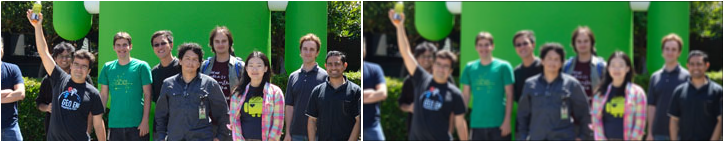

In [93]:
-- This matrix has the effect of assigning the average pixel value at each location.
local cropped_image = image.crop(rgb_image, 140, 140, 500, 280)
local weights = torch.FloatTensor{{1/9, 1/9, 1/9},
                                  {1/9, 1/9, 1/9},
                                  {1/9, 1/9, 1/9}}

-- The parameter 'same' zero-pads the input image so that the output image of
-- the convolution has exactly the same size as the input image so we can visualize them side by side.
local filtered_image = image.convolve(cropped_image, weights, 'same')

itorch.image({cropped_image, filtered_image}) -- show input and output.

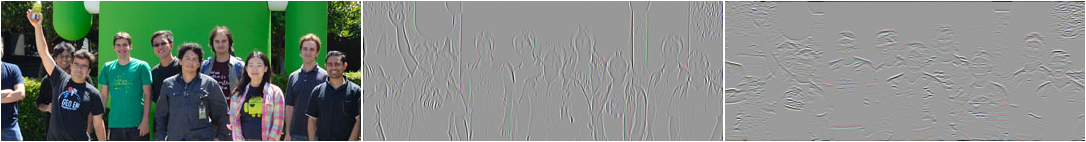

In [97]:
local cropped_image = image.crop(rgb_image, 140, 140, 500, 280)

-- This filter is designed to highlight vertical edges.
local weights = torch.FloatTensor{{1, -2, 1},
                                  {1, -2, 1},
                                  {1, -2, 1}}

-- convolve with the input filter.
local filtered_image1 = image.convolve(cropped_image, weights, 'same')
-- convolve with the transpose of the input filter (highlight horizontal edges).
local filtered_image2 = image.convolve(cropped_image, weights:t(), 'same')

-- make filtered images between 0 and 1.
filtered_image1 = (filtered_image1 - filtered_image1:min()):div(filtered_image1:max() - filtered_image1:min())
filtered_image2 = (filtered_image2 - filtered_image2:min()):div(filtered_image2:max() - filtered_image2:min())

-- show the input image along with the two filtered images.
itorch.image({cropped_image, filtered_image1, filtered_image2}) -- show input and output.

In the example below we show that we can apply a different set of weights to each channel of the image by using a patch from the same image as the convolutional filter (the weights). 

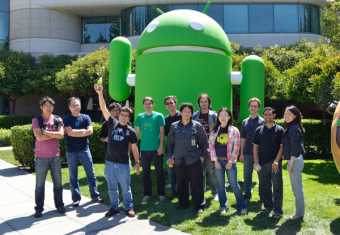

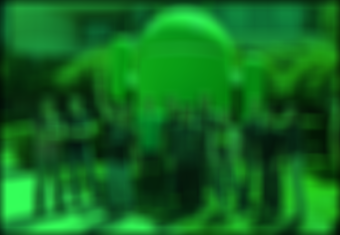

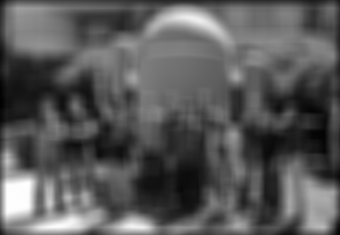

In [223]:
-- use a patch from the image as the convolutional filter (the weights).
local patch = image.crop(rgb_image, 436, 142, 460, 170) -- this is a piece from the Android.
itorch.image(patch) -- show the image patch.

-- make the convolution using this image patch as filter.
local filtered_image = image.convolve(rgb_image, patch, 'same')

itorch.image(image.scale(rgb_image, 340))
itorch.image(image.scale(filtered_image, 340))
-- add the three response maps to compute the linear response map of the convolution.
itorch.image(image.scale(filtered_image:sum(1):squeeze(), 340))

In the following example we pick a patch from the leg of a person and we convolve this patch with the original image. By now you probably already guessed that filtering (or convolving) the image with a given patch enhances the parts of the image that are similar to the given filter (weight matrix).

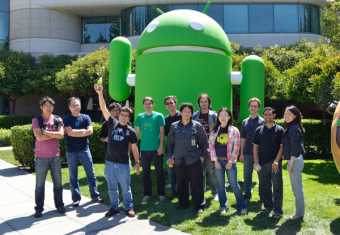

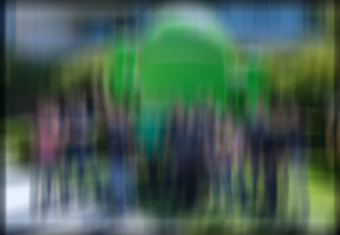

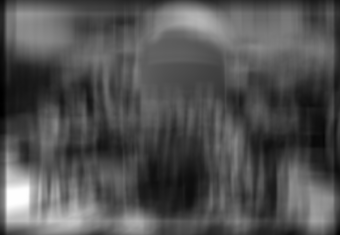

In [224]:
-- use another patch from the image as the convolutional filter (the weights).
local patch = image.crop(rgb_image, 58, 330, 84, 380) -- this is a leg.
itorch.image(patch) -- show the image patch.

-- make the convolution using this image patch as filter.
local filtered_image = image.convolve(rgb_image, patch, 'same')

itorch.image(image.scale(rgb_image, 340))
itorch.image(image.scale(filtered_image, 340))
-- add the three response maps to compute the linear response map of the convolution.
itorch.image(image.scale(filtered_image, 340):sum(1):squeeze())

## Exercises
- Show separately in grayscale the LAB (rgb2lab) channels here corresponding to our test image and give an intuitive interpretation of each channel.
- Plot histograms for the channels in the Lab image representation.
- Write code that can amplify saturation for a given image by 1.5 and show the input and output.
- Convolve the image with other different patches and show any interesting effect.

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@cs.virginia.edu